# Tabular Playground Series - Jun 2021

## Dependencies

In [23]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

SEED = 2502
DATA_PATH = "../data/tabular-playground-series-jun-2021/"

In [24]:
print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

PyTorch версия: 2.10.0+cu128
CUDA доступна: True
Используемое устройство: cuda


## Data

In [25]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_test = pd.read_csv(DATA_PATH + "test.csv")

df_train['target'] = df_train['target'].str.replace("Class_", '').astype(int) - 1
df_train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,...,0,0,0,0,0,0,2,0,0,5
1,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,5
2,2,0,0,0,0,0,1,0,3,0,...,0,0,0,0,1,0,0,0,0,1
3,3,0,0,7,0,1,5,2,2,0,...,0,4,0,2,2,0,4,3,0,7
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### EDA

In [26]:
df_train.shape

(200000, 77)

200000 rows \
77 columns:
- 1 id
- 75 anonymized features
- 1 target (multiclass)

In [27]:
df_train['id'].describe()

count    200000.000000
mean      99999.500000
std       57735.171256
min           0.000000
25%       49999.750000
50%       99999.500000
75%      149999.250000
max      199999.000000
Name: id, dtype: float64

In [28]:
df_test['id'].describe()

count    100000.000000
mean     249999.500000
std       28867.657797
min      200000.000000
25%      224999.750000
50%      249999.500000
75%      274999.250000
max      299999.000000
Name: id, dtype: float64

In [29]:
set(df_train.dtypes.values)

{dtype('int64')}

In [30]:
df_train.isna().sum().sum()

np.int64(0)

In [31]:
num_classes = df_train['target'].nunique()
num_classes

9

9 classes

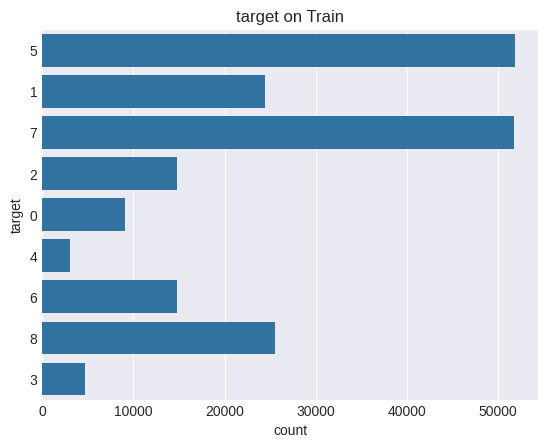

In [32]:
sns.countplot(df_train['target'].astype(str))
plt.title("target on Train")
plt.show()

### Dataset preparing

In [33]:
cols2drop = ['id']
target = 'target'
features = df_train.drop(columns=cols2drop + [target], errors='ignore').columns

X = df_train[features].to_numpy()
y = df_train[target].to_numpy()

In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y, shuffle=True
)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
# )

scaler_w = StandardScaler()
X_train = scaler_w.fit_transform(X_train)
X_val = scaler_w.transform(X_val)
# X_test = scaler_w.transform(X_test)

In [35]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)
# X_test_t = torch.FloatTensor(X_test)
# y_test_t = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=2**14, shuffle=True, num_workers=8)
val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=2**14, shuffle=False, num_workers=8)

## Model

In [36]:
class MultiClassClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.network(x)

model = MultiClassClassifier(input_dim=X_train.shape[1], num_classes=num_classes).to(device)
print(model)

MultiClassClassifier(
  (network): Sequential(
    (0): Linear(in_features=75, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=9, bias=True)
  )
)


In [ ]:
class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.3):
        super(AdvancedMLP, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

model = AdvancedMLP(input_dim=X_train.shape[1], hidden_dims=[128, 64, 64, 32], output_dim=num_classes).to(device)
print(model)

AdvancedMLP(
  (network): Sequential(
    (0): Linear(in_features=75, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=32, out_features=9, bias=True)
  )
)


### Criterion & Optimizer

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

## Train

In [39]:
num_epochs = 200
train_losses_w, val_losses_w = [], []
train_accs_w, val_accs_w = [], []
best_val_loss = float('inf') 
patience_w, counter_w = 20, 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(logits, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    train_losses_w.append(train_loss)
    train_accs_w.append(train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch)

            val_loss += loss.item()
            _, preds = torch.max(logits, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses_w.append(val_loss)
    val_accs_w.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter_w = 0
        torch.save(model.state_dict(), '../models/best_model.pth')
    else:
        counter_w += 1
        if counter_w >= patience_w:
            print(f"Early stopping на эпохе {epoch+1} (val_loss не уменьшался)")
            break

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss (LogLoss): {val_loss:.4f} Acc: {val_acc:.4f}")

print(f"\nЛучший результат (min val_loss): {best_val_loss:.4f}")


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch  20 | Train Loss: 1.8093 Acc: 0.3429 | Val Loss (LogLoss): 1.7769 Acc: 0.3497
Epoch  40 | Train Loss: 1.7893 Acc: 0.3499 | Val Loss (LogLoss): 1.7669 Acc: 0.3538
Epoch  60 | Train Loss: 1.7794 Acc: 0.3545 | Val Loss (LogLoss): 1.7617 Acc: 0.3554
Epoch  80 | Train Loss: 1.7724 Acc: 0.3562 | Val Loss (LogLoss): 1.7595 Acc: 0.3541
Epoch 100 | Train Loss: 1.7652 Acc: 0.3598 | Val Loss (LogLoss): 1.7575 Acc: 0.3555
Epoch 120 | Train Loss: 1.7607 Acc: 0.3625 | Val Loss (LogLoss): 1.7567 Acc: 0.3561
Epoch 140 | Train Loss: 1.7561 Acc: 0.3629 | Val Loss (LogLoss): 1.7570 Acc: 0.3557
Early stopping на эпохе 149 (val_loss не уменьшался)

Лучший результат (min val_loss): 1.7566


In [40]:
# model.load_state_dict(torch.load('../models/best_model.pth'))
# model.eval()

# with torch.no_grad():
#     logits = model(X_test_t.to(device))

# test_logloss = criterion(logits, y_test_t.to(device))
# test_logloss

## Generating submission

In [41]:
X_k_test = df_test[features].to_numpy()
X_k_test = scaler_w.transform(X_k_test)
X_k_test_t = torch.FloatTensor(X_k_test)

In [42]:
model.load_state_dict(torch.load('../models/best_model.pth'))
model.eval()

with torch.no_grad():
    logits = model(X_k_test_t.to(device))

probs = F.softmax(logits, dim=1).to("cpu")
probs

tensor([[0.0637, 0.3810, 0.1600,  ..., 0.0259, 0.0557, 0.1329],
        [0.0411, 0.0406, 0.0356,  ..., 0.0943, 0.3710, 0.1139],
        [0.0223, 0.0274, 0.0203,  ..., 0.0293, 0.1418, 0.0583],
        ...,
        [0.0618, 0.3153, 0.1542,  ..., 0.0392, 0.0876, 0.1480],
        [0.0376, 0.0391, 0.0334,  ..., 0.0748, 0.2976, 0.1008],
        [0.0463, 0.1040, 0.0743,  ..., 0.0660, 0.2053, 0.1350]])

In [43]:
sample_submission = pd.read_csv(DATA_PATH + "sample_submission.csv")
sample_submission.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
1,200001,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
2,200002,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
3,200003,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
4,200004,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111


In [44]:
subm = pd.DataFrame(probs)
subm.columns = [f"Class_{i + 1}" for i in range(9)]
subm = pd.concat([sample_submission['id'], subm], axis=1)
subm.to_csv("../sumbissions/subm.csv", index=False)
subm.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.063652,0.380972,0.159994,0.029052,0.012203,0.139657,0.025871,0.055679,0.132920
1,200001,0.041088,0.040619,0.035578,0.018210,0.013236,0.272063,0.094341,0.371008,0.113857
2,200002,0.022340,0.027435,0.020283,0.007496,0.003986,0.689054,0.029327,0.141778,0.058302
3,200003,0.043036,0.070863,0.054703,0.021792,0.014045,0.324929,0.076045,0.266081,0.128507
4,200004,0.046209,0.090599,0.067710,0.025709,0.016609,0.290170,0.076497,0.247407,0.139090
